Fetch data (~52MB) from gdrive

In [1]:
import gdown
import os

In [2]:
mode = 'filter_promo'
# mode = 'regular'

result_path = ''
cache_path = '.cache'
os.makedirs(cache_path, exist_ok=True)
if mode == 'filter_promo':
    result_path = os.path.join(cache_path, mode + '.json')
    gdown.cached_download('https://drive.google.com/file/d/13sfpm8p7ITeJJX0gVxSJhrTwFt2LUh5t/view?usp=sharing',
                         result_path, fuzzy=True)
elif mode == 'regular':
    result_path = os.path.join(cache_path, mode + '.json')
    gdown.cached_download('https://drive.google.com/file/d/1GJ7E6QGOFCL1VOHkCyOUftks9DBC-E3I/view?usp=sharing',
                         result_path, fuzzy=True)
else:
    raise Exception('unknown mode ' + mode)

Cached Downloading: .cache/filter_promo.json
Downloading...
From: https://drive.google.com/uc?id=13sfpm8p7ITeJJX0gVxSJhrTwFt2LUh5t
To: /Users/leonhards/.cache/gdown/tmp2psv1b1m/dl
100%|██████████| 5.50M/5.50M [00:00<00:00, 28.2MB/s]


In [3]:
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.ticker
from paper import *

In [4]:
adjust_settings()

/Users/leonhards/projects/tuplex-public/experimental/notebooks/paper.py:36: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])


In [5]:
with open(result_path, 'r') as fp:
    data = fp.read()

In [6]:
lines = data.strip().split('\n')
len(lines)

22

In [7]:
d = [json.loads(line) for line in lines]
df = pd.DataFrame(d)

In [8]:
df.columns

Index(['buf_size_compressed', 'buf_size_uncompressed', 'event_to_filter_for',
       'fallback_mem', 'fallback_rows', 'filter_promotion', 'general_case',
       'general_case_field_count', 'general_json_paths', 'general_mem',
       'general_rows', 'mode', 'normal_case', 'normal_case_field_count',
       'normal_json_paths', 'normal_mem', 'normal_rows', 'path',
       'perfect_sample', 'sample_row_count', 'sample_size', 'total_rows',
       'type_counts'],
      dtype='object')

In [9]:
df['year'] = df['path'].apply(lambda x: x.replace('.json.gz', '')).apply(lambda x: x[x.rfind('/')+1:].split('-')[0]).astype(int)

In [10]:
df[df['mode'] == 'hyper'].sort_values(by=['year'])['total_rows']

10      48899
9      165692
8      296456
7      476393
6      737714
5      678134
4      910100
3     1522655
2     2134789
1     2963694
0     1078139
Name: total_rows, dtype: int64

In [11]:
df[df['mode'] == 'global'].sort_values(by=['year'])['total_rows']

21      48899
20     165692
19     296456
18     476393
17     737714
16     678134
15     910100
14    1522655
13    2134789
12    2963694
11    1078139
Name: total_rows, dtype: int64

sanity check done, now let's plot them next to each other

In [12]:
df_hyper = df[df['mode'] == 'hyper'].sort_values(by=['year'])
df_global = df[df['mode'] == 'global'].sort_values(by=['year'])

plot nice overview over data

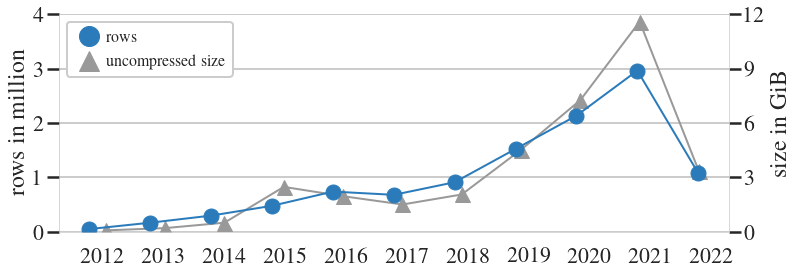

In [13]:
plt.figure(figsize=(12, 4))

primary_col = sns.color_palette('Blues')[-2]
secondary_col = [0.6]*3


ax1 = plt.gca()
xq = np.arange(len(df_global))
oct_offset = 288/365 # ignore leap year
ax1.plot(xq + oct_offset, df_global['total_rows'] / 10**6, marker='o',
         color=primary_col, markersize=15, linewidth=2)

ax1.set_ylabel('rows in million')
ax1.set_ylim(0, 4)
xt = np.array([0, 1, 2, 3, 4])
ax1.set_yticks(xt)
ax2 = ax1.twinx()
ax2.plot(xq + oct_offset, df_global['buf_size_uncompressed'] / (1024**3),
         color=secondary_col, marker='^', markersize=15,
        linewidth=2)
ax2.set_ylim(0, 12)
ax2.set_yticks(xt * 3)
ax2.set_ylabel('size in GiB')

# fix for ordering
ax2.zorder=0
ax1.zorder=1
ax1.patch.set_visible(False)

lgd_handles = []
lgd_handles.append(Line2D([0], [0], marker='o', color=primary_col, label='rows',
                   markerfacecolor=primary_col, markersize=20, linewidth=0))
lgd_handles.append(Line2D([0], [0], marker='^', color=secondary_col, label='uncompressed size',
                   markerfacecolor=secondary_col, markersize=20, linewidth=0))
ax1.legend(handles=lgd_handles, fontsize=16, handletextpad=0.05, facecolor='w', framealpha=1)

#sns.despine()
xq = np.arange(len(df_global) + 1)

# ax1.grid(axis='y')
ax1.grid(False)
# ax2.grid(axis='x')
plt.xticks(xq, list(df_global['year'].values) + ['2022'], visible=True, rotation="vertical")
plt.savefig(mode + '_peryear_data_overview.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

plot number of fields over years

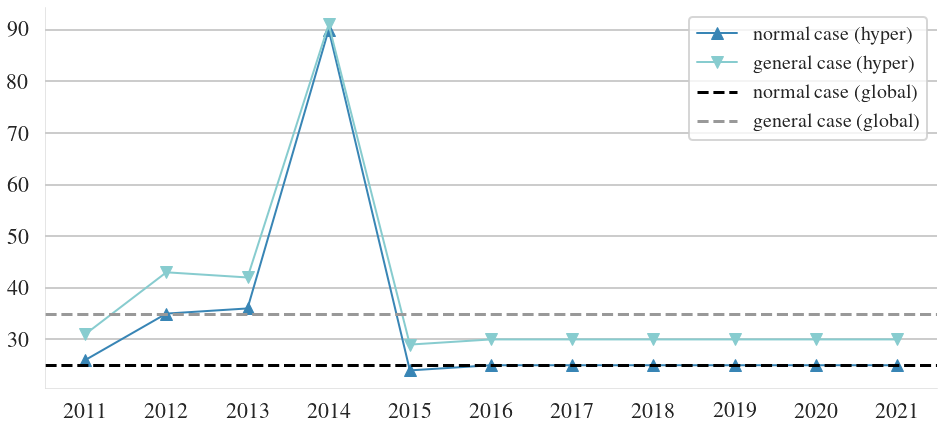

In [34]:
plt.figure(figsize=(16,7))
plt.plot(df_hyper['year'], df_hyper['normal_case_field_count'],
         marker='^', linewidth=2, label='normal case (hyper)')
plt.plot(df_hyper['year'], df_hyper['general_case_field_count'],
         marker='v', linewidth=2, label='general case (hyper)')
plt.axhline(df_global['normal_case_field_count'].iloc[0], linewidth=3,
            linestyle='--',
            color='k', label='normal case (global)')
plt.axhline(df_global['general_case_field_count'].iloc[0], linewidth=3, linestyle='--',
            color=[0.6]*3, label='general case (global)')
plt.legend(fontsize=20)
if mode == 'regular':
    plt.yscale('log')
    plt.yticks([1, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000])
    plt.ylim([10, 1500])
    
plt.xticks(df_hyper['year'])

def fmt(x, pos):
    return str(int(x))
ax = plt.gca()
#ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 10 ** 7, 0.5 * 10**6)))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmt))

sns.despine()
plt.grid(axis='x')
plt.savefig(mode + '_peryear_schema_complexity.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

In [15]:
# general case complexity:
print('normal  case (global): {} fields'.format(df_global['normal_case_field_count'].iloc[0]))
print('general case (global): {} fields'.format(df_global['general_case_field_count'].iloc[0]))

normal  case (global): 25 fields
general case (global): 35 fields


In [16]:
# normal case complexity
print('normal  case (hyper): {} - {} fields'.format(df_hyper['normal_case_field_count'].min(),
                                                   df_hyper['normal_case_field_count'].max()))
print('general case (hyper): {} - {} fields'.format(df_hyper['general_case_field_count'].min(),
                                                   df_hyper['general_case_field_count'].max()))

normal  case (hyper): 24 - 90 fields
general case (hyper): 29 - 91 fields


In [38]:
df_hyper[df_hyper['year'] == 2014][['normal_mem', 'general_mem', 'fallback_mem']]

,normal_mem,general_mem,fallback_mem
7,8438752,9730715,1102230118


In [39]:
df_hyper[df_hyper['year'] == 2014][['normal_rows', 'general_rows', 'fallback_rows']]

,normal_rows,general_rows,fallback_rows
7,240251,2245,233897


In [17]:
def plot_bars(subdf, xoff, w, c1, c2, c3):
    xq = np.arange(len(subdf))
    plt.bar(xq + xoff, subdf['normal_rows'],  w, color=c1)
    plt.bar(xq + xoff, subdf['general_rows'], w, bottom=subdf['normal_rows'], color=c2)
    plt.bar(xq + xoff, subdf['fallback_rows'], w, bottom=subdf['normal_rows'] + subdf['general_rows'], color=c3)
    
def plot_bars_mem(subdf, xoff, w, mem_factor, c1, c2, c3):
    xq = np.arange(len(subdf))
    plt.bar(xq + xoff, subdf['normal_mem'] / mem_factor,  w, color=c1)
    plt.bar(xq + xoff, subdf['general_mem'] / mem_factor, w, bottom=subdf['normal_mem'] / mem_factor, color=c2)
    plt.bar(xq + xoff, subdf['fallback_mem'] / mem_factor, w, bottom=subdf['normal_mem']  / mem_factor + subdf['general_mem']  / mem_factor, color=c3)

done


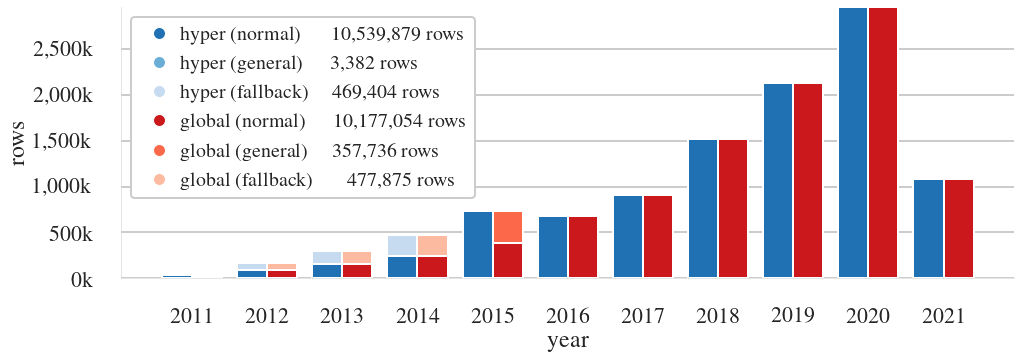

In [18]:
plt.figure(figsize=(16, 5))
handles =[]
c1, c2, c3 = sns.color_palette('Blues', 3)[::-1]
plot_bars(df_hyper, -.2, 0.4, c1, c2 , c3)
normal = df_hyper['normal_rows'].sum()
general = df_hyper['general_rows'].sum()
fallback = df_hyper['fallback_rows'].sum()
handles += [(f'hyper (normal)    \\,\\,\\quad{normal:,} rows', c1),
            (f'hyper (general)   \\,\\quad{general:,} rows', c2),
            (f'hyper (fallback)  \\quad {fallback:,} rows', c3)]
c1, c2, c3 = sns.color_palette('Reds', 3)[::-1]
normal =   df_global['normal_rows'].sum()
general =  df_global['general_rows'].sum()
fallback = df_global['fallback_rows'].sum()
handles += [(f'global (normal)   \\;\\,\\,\\,\\, {normal:,} rows', c1),
            (f'global (general)  \\quad {general:,} rows', c2),
            (f'global (fallback) \\quad\; {fallback:,} rows', c3)]
plot_bars(df_global, .2, 0.4, c1, c2, c3)
xq = np.arange(len(df_hyper))
plt.xticks(xq, df_hyper['year'])
print('done')
sns.despine()
plt.ylabel('rows')
plt.xlabel('year')

plt.grid(axis='x')

# https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
lgd_handles=[]
for h in handles:
    lgd_handles.append(Line2D([0], [0], marker='o', color='w', label=h[0],
                        markerfacecolor=h[1], markersize=12))
ax = plt.gca()
ax.legend(loc='best', handles=lgd_handles, fontsize=20, handletextpad=0.05, facecolor='w', framealpha=1)

def fmt(x, pos):
    k = int(x / 10**3)
    return  f'{k:,}' + 'k'

ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 10 ** 7, 0.5 * 10**6)))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmt))
ax.tick_params(which = 'major', length = 25)

plt.savefig(mode + '_peryear_data_fullschema.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

done


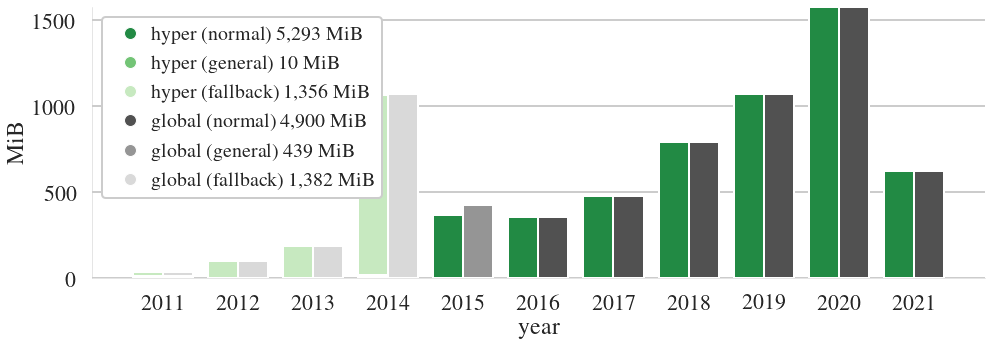

In [19]:
plt.figure(figsize=(16, 5))
handles =[]
c1, c2, c3 = sns.color_palette('Greens', 3)[::-1]
mem_factor = 1024 * 1024
mem_unit = 'MiB'
plot_bars_mem(df_hyper, -.2, 0.4, mem_factor, c1, c2 , c3)
normal = int(df_hyper['normal_mem'].sum() / mem_factor)
general = int(df_hyper['general_mem'].sum() / mem_factor)
fallback = int(df_hyper['fallback_mem'].sum() / mem_factor)
handles += [(f'hyper (normal)    {normal:,} {mem_unit}', c1),
            (f'hyper (general)   {general:,} {mem_unit}', c2),
            (f'hyper (fallback)  {fallback:,} {mem_unit}', c3)]
c1, c2, c3 = sns.color_palette('Greys', 3)[::-1]
normal =   int(df_global['normal_mem'].sum() / mem_factor)
general =  int(df_global['general_mem'].sum() / mem_factor)
fallback = int(df_global['fallback_mem'].sum() / mem_factor)
handles += [(f'global (normal)    {normal:,} {mem_unit}', c1),
            (f'global (general)     {general:,} {mem_unit}', c2),
            (f'global (fallback) {fallback:,} {mem_unit}', c3)]
plot_bars_mem(df_global, .2, 0.4, mem_factor, c1, c2, c3)
xq = np.arange(len(df_hyper))
plt.xticks(xq, df_hyper['year'])
print('done')
sns.despine()
plt.ylabel(mem_unit)
plt.xlabel('year')

plt.grid(axis='x')

# https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
lgd_handles=[]
for h in handles:
    lgd_handles.append(Line2D([0], [0], marker='o', color='w', label=h[0],
                        markerfacecolor=h[1], markersize=12))
ax = plt.gca()
ax.legend(loc='best', handles=lgd_handles, fontsize=20, handletextpad=0.05, facecolor='w', framealpha=1)
plt.savefig(mode + '_peryear_data_fullschema_memory.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

In [20]:
# interpolation for full dataset (pretty off)
hyper_total = df_hyper['normal_mem'].sum() + df_hyper['general_mem'].sum() + df_hyper['fallback_mem'].sum()
global_total = df_global['normal_mem'].sum() + df_global['general_mem'].sum() + df_global['fallback_mem'].sum()

print('memory usage:: hyper {:.1f} MiB  global {:.1f} MiB'.format(
    hyper_total / mem_factor, global_total / mem_factor))

print('memory usage:: hyper {:.1f} GiB  global {:.1f} GiB'.format(
    hyper_total / (mem_factor * 1024), global_total / (mem_factor * 1024)))

memory usage:: hyper 6660.6 MiB  global 6722.8 MiB
memory usage:: hyper 6.5 GiB  global 6.6 GiB


In [21]:
pct_reduction = 100.0 * (1.0 - hyper_total / global_total)
print('hyper reduced overall footprint by {}%'.format(pct_reduction))

hyper reduced overall footprint by 0.9256820604997107%


In [22]:
# averages per row may be also interesting:

print('encoding 1 row in normal   (hyper): {:.2f} Kib'.format(
    df_hyper['normal_mem'].sum() / df_hyper['normal_rows'].sum() / 1024))
print('encoding 1 row in general  (hyper): {:.2f} Kib'.format(
    df_hyper['general_mem'].sum() / df_hyper['general_rows'].sum() / 1024))
print('encoding 1 row in fallback (hyper): {:.2f} Kib'.format(
    df_hyper['fallback_mem'].sum() / df_hyper['fallback_rows'].sum() / 1024))
print('----')
print('encoding 1 row in normal   (global): {:.2f} Kib'.format(
    df_global['normal_mem'].sum() / df_global['normal_rows'].sum() / 1024))
print('encoding 1 row in general  (global): {:.2f} Kib'.format(
    df_global['general_mem'].sum() / df_global['general_rows'].sum() / 1024))
print('encoding 1 row in fallback (global): {:.2f} Kib'.format(
    df_global['fallback_mem'].sum() / df_global['fallback_rows'].sum() / 1024))

encoding 1 row in normal   (hyper): 0.51 Kib
encoding 1 row in general  (hyper): 3.16 Kib
encoding 1 row in fallback (hyper): 2.96 Kib
----
encoding 1 row in normal   (global): 0.49 Kib
encoding 1 row in general  (global): 1.26 Kib
encoding 1 row in fallback (global): 2.96 Kib


How many unique normal-cases exist in hyper?

In [49]:
len(df_hyper['normal_case'].unique()), len(df_global['normal_case'].unique())

(7, 1)

How many unique general-cases exist in hyper?

In [50]:
len(df_hyper['general_case'].unique()), len(df_global['general_case'].unique())

(6, 1)

some more analysis (specific for promotion)

In [40]:
df_hyper[['normal_rows', 'general_rows', 'fallback_rows']]

,normal_rows,general_rows,fallback_rows
10,31937,0,16962
9,88848,482,76362
8,153618,655,142183
7,240251,2245,233897
6,737714,0,0
5,678134,0,0
4,910100,0,0
3,1522655,0,0
2,2134789,0,0
1,2963694,0,0


In [41]:
df_global[['normal_rows', 'general_rows', 'fallback_rows']]

,normal_rows,general_rows,fallback_rows
21,24825,7112,16962
20,87720,0,77972
19,151527,0,144929
18,238381,0,238012
17,387090,350624,0
16,678134,0,0
15,910100,0,0
14,1522655,0,0
13,2134789,0,0
12,2963694,0,0


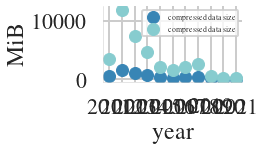

In [23]:
plt.plot(df_hyper['buf_size_compressed'] / mem_factor, 'o', label='compressed data size')
plt.plot(df_hyper['buf_size_uncompressed'] / mem_factor, 'o', label='compressed data size')
plt.xticks(xq, df_hyper['year'])
sns.despine()
plt.ylabel(mem_unit)
plt.xlabel('year')

plt.legend(loc='best')

In [24]:
# require filter promotion etc. to get a better fit? E.g., a restrictive filter on years 2015 and 2016 could do.

In [42]:
# least complex normal-case
sorted(list(df['normal_case'].values), key=len)[0]

"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]"

In [43]:
# most complex normal-case
sorted(list(df['normal_case'].values), key=len)[-1]

"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'login'->str),(str,'type'->str),(str,'gravatar_id'->str),(str,'name'->str),(str,'company'->str),(str,'blog'->str),(str,'location'->str),(str,'email'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'shas'->List[(str,str,str,str,boolean)]),(str,'size'->i64),(str,'ref'->str),(str,'head'->str)]),(str,'public'->boolean),(str,'repository'->Struct[(str,'archive_url'->str),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'description'->Option[str]),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full_name'->str),(str,'git_commits_url'->str),(str,'git_refs_ur

In [44]:
# least complex general_case
sorted(list(df['general_case'].values), key=len)[0]

"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]"

In [45]:
# most complex general_case
sorted(list(df['general_case'].values), key=len)[-1]

"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'blog'=>str),(str,'company'=>str),(str,'email'->str),(str,'gravatar_id'->str),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'shas'->List[(str,str,str,str,boolean)]),(str,'size'->i64),(str,'ref'->str),(str,'head'->str)]),(str,'public'->boolean),(str,'repository'->Struct[(str,'archive_url'->str),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'description'->Option[str]),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full_name'->str),(str,'git_commits_url'->str),(str,'git_refs_ur

In [46]:
df_global['normal_case'].iloc[0]

"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]"

In [47]:
df_global['general_case'].iloc[0]

"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'before'=>str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'=>boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'=>i64),(str,'head'->str),(str,'legacy'=>Struct[(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'shas'->List[List[Option[str]]]),(str,'size'->i64)]),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]"

In [48]:
df_hyper['total_rows']

10      48899
9      165692
8      296456
7      476393
6      737714
5      678134
4      910100
3     1522655
2     2134789
1     2963694
0     1078139
Name: total_rows, dtype: int64

In [32]:
# -> prob. picks up the wrong normal-case/global case... -> selection routine may be off...

Improvements:
    
    - pick specific day (October 15th :P?)
    - combine data for the day (so it's larger)
    - rerun this experiment

Observations: 

    -> why is there nearly no general-case matching in the global specialization case?

--> perform pushdown (PushEvent?)

--> then map function